# Timeseries visualizations of snow depth and others parameters at Tichki station (lat:31.53 ,lon:-6.30 ,alt:3260m ) over the period 2001-2010

## 1. Import python models

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import datetime as dt
import calendar as cld
import matplotlib.pyplot as plt
import xarray as xr
from os import listdir
from os.path import isfile, join
import cartopy.crs as ccrs
import cartopy 
import proplot as plot  # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import sys
import calendar
import time
import matplotlib.image as mpimg  
import datetime

## 2. Data wrangling and auxiliary functions

In [2]:
# The data file is an xlsx file,  
path_snow_depth_data = '/home/hchaabani/snow_data/in_situ_sd/Draa_Mgoun'
tichki = pd.read_excel(path_snow_depth_data+"/Fulld_Tichki_Clean.xlsx")  

In [3]:
tichki.drop([0], axis=0, inplace=True)

In [4]:
tichki

ID        date    year  month   day  rh_2 at_2  net  rad  sut  ...  \
1     99.0  04.04.2001  2001.0    4.0   4.0    40  3.9  121  308  NaN  ...   
2     99.0  05.04.2001  2001.0    4.0   5.0    36  4.8   95  320  NaN  ...   
3     99.0  06.04.2001  2001.0    4.0   6.0    33  6.1   96  325  NaN  ...   
4     99.0  07.04.2001  2001.0    4.0   7.0    28  7.1  116  326  NaN  ...   
5     99.0  08.04.2001  2001.0    4.0   8.0    22  7.8   91  331  NaN  ...   
...    ...         ...     ...    ...   ...   ...  ...  ...  ...  ...  ...   
3559  99.0  31.12.2010  2010.0   12.0  31.0  21.7  0.5   17  166  1.5  ...   
3560  99.0  01.01.2011  2011.0    1.0   1.0  18.3  0.6   -5  165  2.3  ...   
3561  99.0  02.01.2011  2011.0    1.0   2.0  34.2  0.3   -1  151  2.1  ...   
3562  99.0  03.01.2011  2011.0    1.0   3.0  43.5  0.7    4  147  2.7  ...   
3563  99.0  04.01.2011  2011.0    1.0   4.0    47  0.7   -3  143  3.1  ...   

        dp at_2_min at_2_min_time at_2_max at_2_max_time wv_2_max  \
1      NaN     -0.5           605      8.3          1210     12.4   
2      NaN        0           620      9.8          1505     10.3   
3      NaN      1.8           455     11.6          1445      9.9   
4      NaN      2.8           525     12.5          1320     12.8   
5      NaN      3.4           415     12.6          1415      9.3   
...    ...      ...           ...      ...           ...      ...   
3559 -20.2     -2.9             0      6.3          1300       10   
3560 -23.3     -2.6           210      5.5          1230     14.4   
3561 -14.4     -2.1           710      4.9          1210     13.9   
3562 -10.7     -1.9          1845      4.5          1140      9.5   
3563  -9.6     -2.2           405      3.7          1220     10.9   

     wv_2_max_time rad_max rad_max_time batt_min  
1              434    1095         1147     12.9  
2             1543    1048         1205     12.9  
3             1800    1049         1218     12.9  
4             1317    1043         1151     12.9  
5             1315    1059         1219     12.9  
...            ...     ...          ...      ...  
3559           937     668         1213     12.8  
3560          2250     651         1207     12.8  
3561            43     839         1332     12.8  
3562          2341     716         1143     12.8  
3563            54     709         1239     12.8  

[3563 rows x 29 columns]

### We select the variables of interest

#### snd_corr : Snow depth in m
#### at_2 : air temperature at 2 m 
#### st-5 : soil temperature at 5cm depth
#### p : precipitation

In [5]:
tichki = tichki[["date", "snd_corr", "at_2", "st-5", "p"]]

In [6]:
tichki 

date snd_corr at_2  st-5  p
1     04.04.2001        0  3.9   8.9  0
2     05.04.2001        0  4.8    10  0
3     06.04.2001        0  6.1    10  0
4     07.04.2001        0  7.1  10.6  0
5     08.04.2001        0  7.8  11.5  0
...          ...      ...  ...   ... ..
3559  31.12.2010        0  0.5   1.6  0
3560  01.01.2011        0  0.6   1.7  0
3561  02.01.2011        0  0.3   1.8  0
3562  03.01.2011        0  0.7   2.3  0
3563  04.01.2011        0  0.7   2.8  0

[3563 rows x 5 columns]

### Setting the date format and filling the missing dates with NaN value over the period 2001-2010
#### Now we have to convert the date into a format suitable for panda objects and fill in the missing dates with NaN

In [7]:
tichki['aux_date'] = np.nan  
# For each dataframe, we fill the 'aux_date' column from coulumn 'date' ('d/m/y to y-m-d')
for l in range(len(tichki)):   
    tichki['aux_date'][l+1] = tichki['date'][l+1][6:10] +'-'+ tichki['date'][l+1][3:5] +'-'+ tichki['date'][l+1][0:2]

/tmp/ipykernel_113873/3704548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['aux_date'] = np.nan
/tmp/ipykernel_113873/3704548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['aux_date'][l+1] = tichki['date'][l+1][6:10] +'-'+ tichki['date'][l+1][3:5] +'-'+ tichki['date'][l+1][0:2]


In [8]:
tichki['aux_date'] = pd.to_datetime(tichki['aux_date'], format='%Y-%m-%d')

/tmp/ipykernel_113873/1273674471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['aux_date'] = pd.to_datetime(tichki['aux_date'], format='%Y-%m-%d')


In [9]:
tichki.set_index('aux_date', inplace=True)

In [10]:
idx = pd.date_range('01/01/2001', '31/12/2010')
for i in range(4):                                       
    tichki = tichki.reindex(idx, fill_value=np.nan)

/home/hchaabani/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '31/12/2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
tichki

date snd_corr at_2 st-5    p
2001-01-01         NaN      NaN  NaN  NaN  NaN
2001-01-02         NaN      NaN  NaN  NaN  NaN
2001-01-03         NaN      NaN  NaN  NaN  NaN
2001-01-04         NaN      NaN  NaN  NaN  NaN
2001-01-05         NaN      NaN  NaN  NaN  NaN
...                ...      ...  ...  ...  ...
2010-12-27  27.12.2010        0  2.7  1.4    0
2010-12-28  28.12.2010        0 -0.1    2    0
2010-12-29  29.12.2010        0 -0.5    2    0
2010-12-30  30.12.2010        0 -2.8  0.9    0
2010-12-31  31.12.2010        0  0.5  1.6    0

[3652 rows x 5 columns]

In [12]:
tichki = tichki.reset_index()

In [13]:
tichki['date']=tichki['index']

In [14]:
tichki

index       date snd_corr at_2 st-5    p
0    2001-01-01 2001-01-01      NaN  NaN  NaN  NaN
1    2001-01-02 2001-01-02      NaN  NaN  NaN  NaN
2    2001-01-03 2001-01-03      NaN  NaN  NaN  NaN
3    2001-01-04 2001-01-04      NaN  NaN  NaN  NaN
4    2001-01-05 2001-01-05      NaN  NaN  NaN  NaN
...         ...        ...      ...  ...  ...  ...
3647 2010-12-27 2010-12-27        0  2.7  1.4    0
3648 2010-12-28 2010-12-28        0 -0.1    2    0
3649 2010-12-29 2010-12-29        0 -0.5    2    0
3650 2010-12-30 2010-12-30        0 -2.8  0.9    0
3651 2010-12-31 2010-12-31        0  0.5  1.6    0

[3652 rows x 6 columns]

#### We will define two new columns with the month and the year for the group by function that we will use in the following.

In [15]:
tichki['year']=np.nan
tichki['month']=np.nan

In [16]:
for i in range(3652):
    tichki['year'][i]=tichki['date'][i].year

/tmp/ipykernel_113873/1242304692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['year'][i]=tichki['date'][i].year


In [17]:
for i in range(3652):
    tichki['month'][i]=tichki['date'][i].month

/tmp/ipykernel_113873/1955449043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['month'][i]=tichki['date'][i].month


In [18]:
# This function astype(numpy.int64) allows to convert a numpy.float64 to int64
tichki['year'] = tichki['year'].astype(np.int64)
tichki['month'] = tichki['month'].astype(np.int64)

In [19]:
tichki

index       date snd_corr at_2 st-5    p  year  month
0    2001-01-01 2001-01-01      NaN  NaN  NaN  NaN  2001      1
1    2001-01-02 2001-01-02      NaN  NaN  NaN  NaN  2001      1
2    2001-01-03 2001-01-03      NaN  NaN  NaN  NaN  2001      1
3    2001-01-04 2001-01-04      NaN  NaN  NaN  NaN  2001      1
4    2001-01-05 2001-01-05      NaN  NaN  NaN  NaN  2001      1
...         ...        ...      ...  ...  ...  ...   ...    ...
3647 2010-12-27 2010-12-27        0  2.7  1.4    0  2010     12
3648 2010-12-28 2010-12-28        0 -0.1    2    0  2010     12
3649 2010-12-29 2010-12-29        0 -0.5    2    0  2010     12
3650 2010-12-30 2010-12-30        0 -2.8  0.9    0  2010     12
3651 2010-12-31 2010-12-31        0  0.5  1.6    0  2010     12

[3652 rows x 8 columns]

In [20]:
tichki = tichki.drop(labels=['index'], axis=1)

In [21]:
tichki

date snd_corr at_2 st-5    p  year  month
0    2001-01-01      NaN  NaN  NaN  NaN  2001      1
1    2001-01-02      NaN  NaN  NaN  NaN  2001      1
2    2001-01-03      NaN  NaN  NaN  NaN  2001      1
3    2001-01-04      NaN  NaN  NaN  NaN  2001      1
4    2001-01-05      NaN  NaN  NaN  NaN  2001      1
...         ...      ...  ...  ...  ...   ...    ...
3647 2010-12-27        0  2.7  1.4    0  2010     12
3648 2010-12-28        0 -0.1    2    0  2010     12
3649 2010-12-29        0 -0.5    2    0  2010     12
3650 2010-12-30        0 -2.8  0.9    0  2010     12
3651 2010-12-31        0  0.5  1.6    0  2010     12

[3652 rows x 7 columns]

In [22]:
tichki['str_date'] = np.nan

In [23]:
for i in range(3652):
    tichki['str_date'][i]=str(tichki['date'][i])[0:10]

/tmp/ipykernel_113873/3762360326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tichki['str_date'][i]=str(tichki['date'][i])[0:10]


In [24]:
tichki

date snd_corr at_2 st-5    p  year  month    str_date
0    2001-01-01      NaN  NaN  NaN  NaN  2001      1  2001-01-01
1    2001-01-02      NaN  NaN  NaN  NaN  2001      1  2001-01-02
2    2001-01-03      NaN  NaN  NaN  NaN  2001      1  2001-01-03
3    2001-01-04      NaN  NaN  NaN  NaN  2001      1  2001-01-04
4    2001-01-05      NaN  NaN  NaN  NaN  2001      1  2001-01-05
...         ...      ...  ...  ...  ...   ...    ...         ...
3647 2010-12-27        0  2.7  1.4    0  2010     12  2010-12-27
3648 2010-12-28        0 -0.1    2    0  2010     12  2010-12-28
3649 2010-12-29        0 -0.5    2    0  2010     12  2010-12-29
3650 2010-12-30        0 -2.8  0.9    0  2010     12  2010-12-30
3651 2010-12-31        0  0.5  1.6    0  2010     12  2010-12-31

[3652 rows x 8 columns]

In [25]:
tichki['str_date'] = pd.to_datetime(tichki['str_date'])
tichki = tichki.set_index('str_date')

In [26]:
tichki

date snd_corr at_2 st-5    p  year  month
str_date                                                  
2001-01-01 2001-01-01      NaN  NaN  NaN  NaN  2001      1
2001-01-02 2001-01-02      NaN  NaN  NaN  NaN  2001      1
2001-01-03 2001-01-03      NaN  NaN  NaN  NaN  2001      1
2001-01-04 2001-01-04      NaN  NaN  NaN  NaN  2001      1
2001-01-05 2001-01-05      NaN  NaN  NaN  NaN  2001      1
...               ...      ...  ...  ...  ...   ...    ...
2010-12-27 2010-12-27        0  2.7  1.4    0  2010     12
2010-12-28 2010-12-28        0 -0.1    2    0  2010     12
2010-12-29 2010-12-29        0 -0.5    2    0  2010     12
2010-12-30 2010-12-30        0 -2.8  0.9    0  2010     12
2010-12-31 2010-12-31        0  0.5  1.6    0  2010     12

[3652 rows x 7 columns]

#### An auxiliary function 

In [27]:
# This auxiliary function will help us in the formatting of the figures
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

## 3. Timeseries visualizations

### Snow depth, air temperature, surface temperature and precipitations time series 

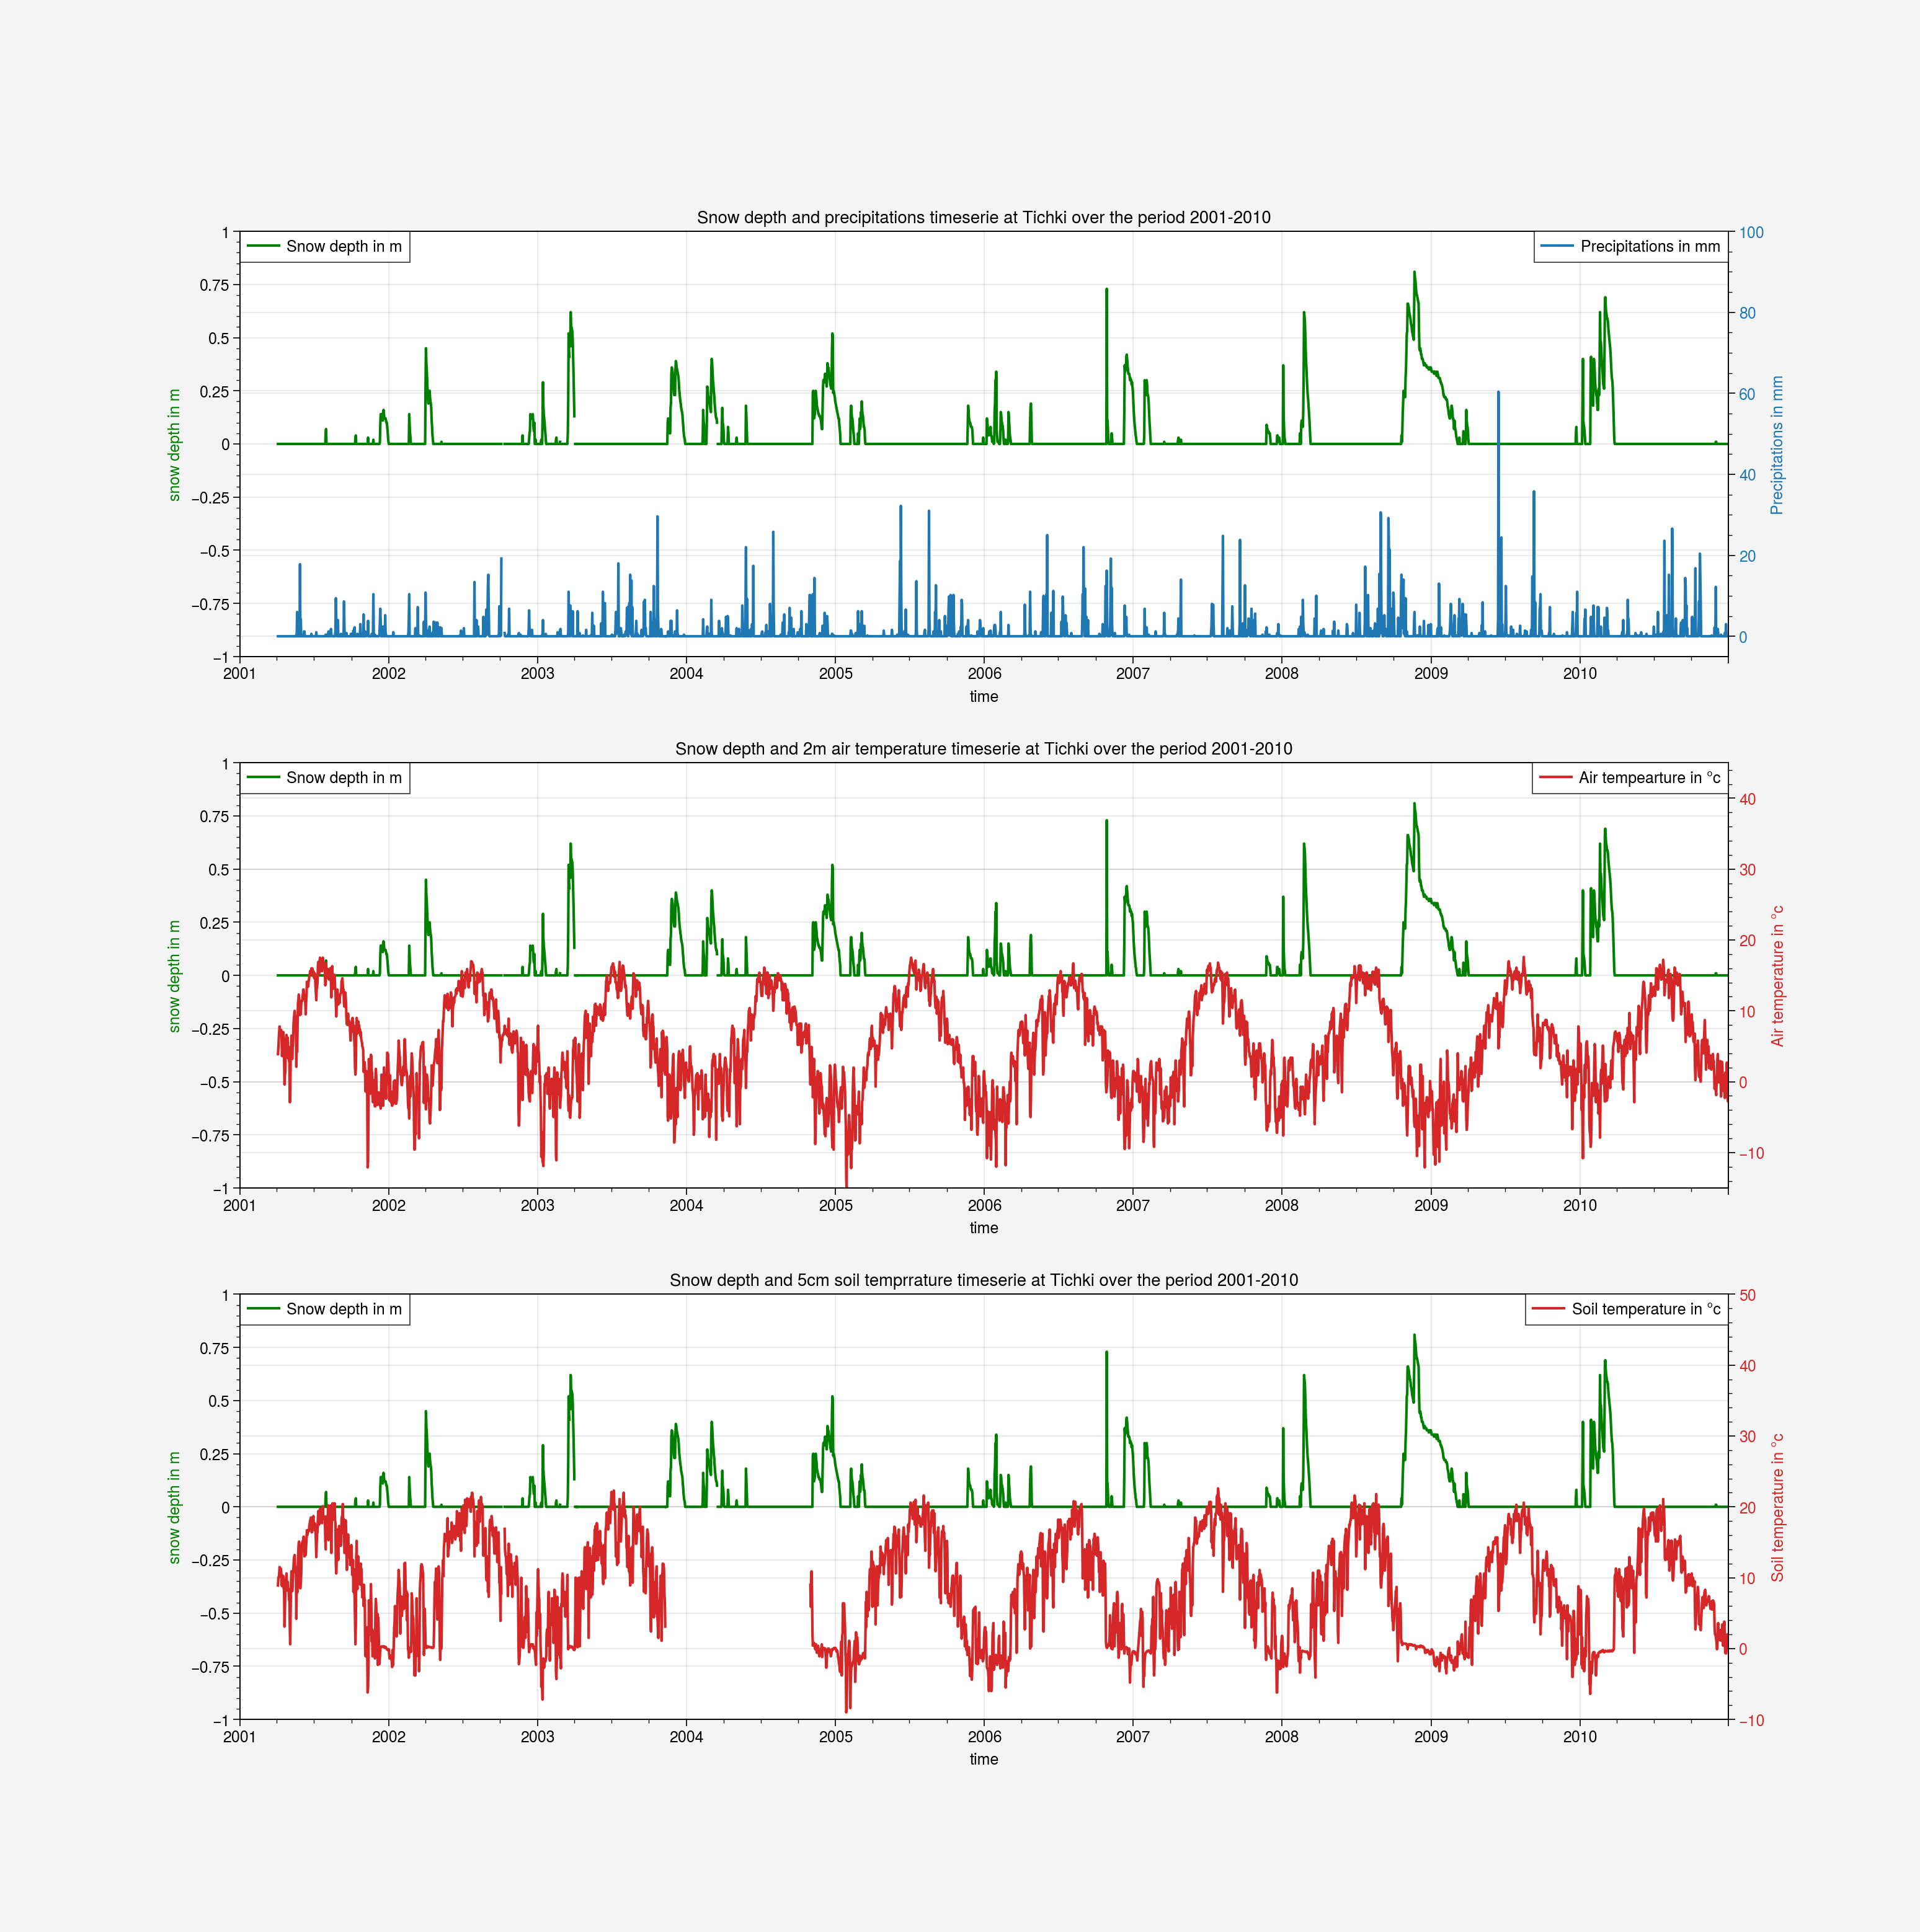

In [28]:
Noms=["Tichki (3260m)"]
fig, axs=plt.subplots(3, 1) 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.1,hspace=0.25)

# We fix the size of figure
set_size(12,12)


color = 'green'
tichki['snd_corr'].plot(ax=axs[0], ylim=[-1,1], color=color) 
axs[0].set_title("Snow depth and precipitations timeserie at Tichki over the period 2001-2010")
axs[0].set_xlabel("time") 
axs[0].legend(labels = ["Snow depth in m"], loc='upper left')
axs[0].set_ylabel("snow depth in m", color=color) 
axs[0].set_ylim(-1,1)

ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'  
ax2.set_ylabel('Precipitations in mm', color=color)  # we already handled the x-label with ax1
tichki['p'].plot(ax=ax2, ylim=[-5,100], color=color) 
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(labels = ["Precipitations in mm"], loc='upper right')
ax2.set_ylim(-5,100)
# =============================================================================================

color = 'green'
tichki['snd_corr'].plot(ax=axs[1], ylim=[-1,1], color=color) 
axs[1].set_title("Snow depth and 2m air temperature timeserie at Tichki over the period 2001-2010")
axs[1].set_xlabel("time") 
axs[1].legend(labels = ["Snow depth in m"], loc='upper left')
axs[1].set_ylabel("snow depth in m", color=color) 
axs[1].set_ylim(-1,1)

ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'  
ax2.set_ylabel('Air temperature in °c', color=color)  # we already handled the x-label with ax1
tichki['at_2'].plot(ax=ax2, ylim=[-15,45], color=color) 
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(labels = ["Air tempearture in °c"], loc='upper right')
ax2.set_ylim(-15,45)

# =============================================================================================

color = 'green'
tichki['snd_corr'].plot(ax=axs[2], ylim=[-1,1], color=color) 
axs[2].set_title("Snow depth and 5cm soil temprrature timeserie at Tichki over the period 2001-2010")
axs[2].set_xlabel("time") 
axs[2].legend(labels = ["Snow depth in m"], loc='upper left')
axs[2].set_ylabel("snow depth in m", color=color) 
axs[2].set_ylim(-1,1)

ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'  
ax2.set_ylabel('Soil temperature in °c', color=color)  # we already handled the x-label with ax1
tichki['st-5'].plot(ax=ax2, ylim=[-10,50], color=color) 
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(labels = ["Soil temperature in °c"], loc='upper right')
ax2.set_ylim(-10,50)


plt.savefig('/home/hchaabani/Desktop/results/Simple_vizualisation_In-situ_data_ SD_and_other_pars_Tichki/fig1.png')

### Snow depth and precipitations timeserie at Tichki during the hydrological years of the period 2001-2010

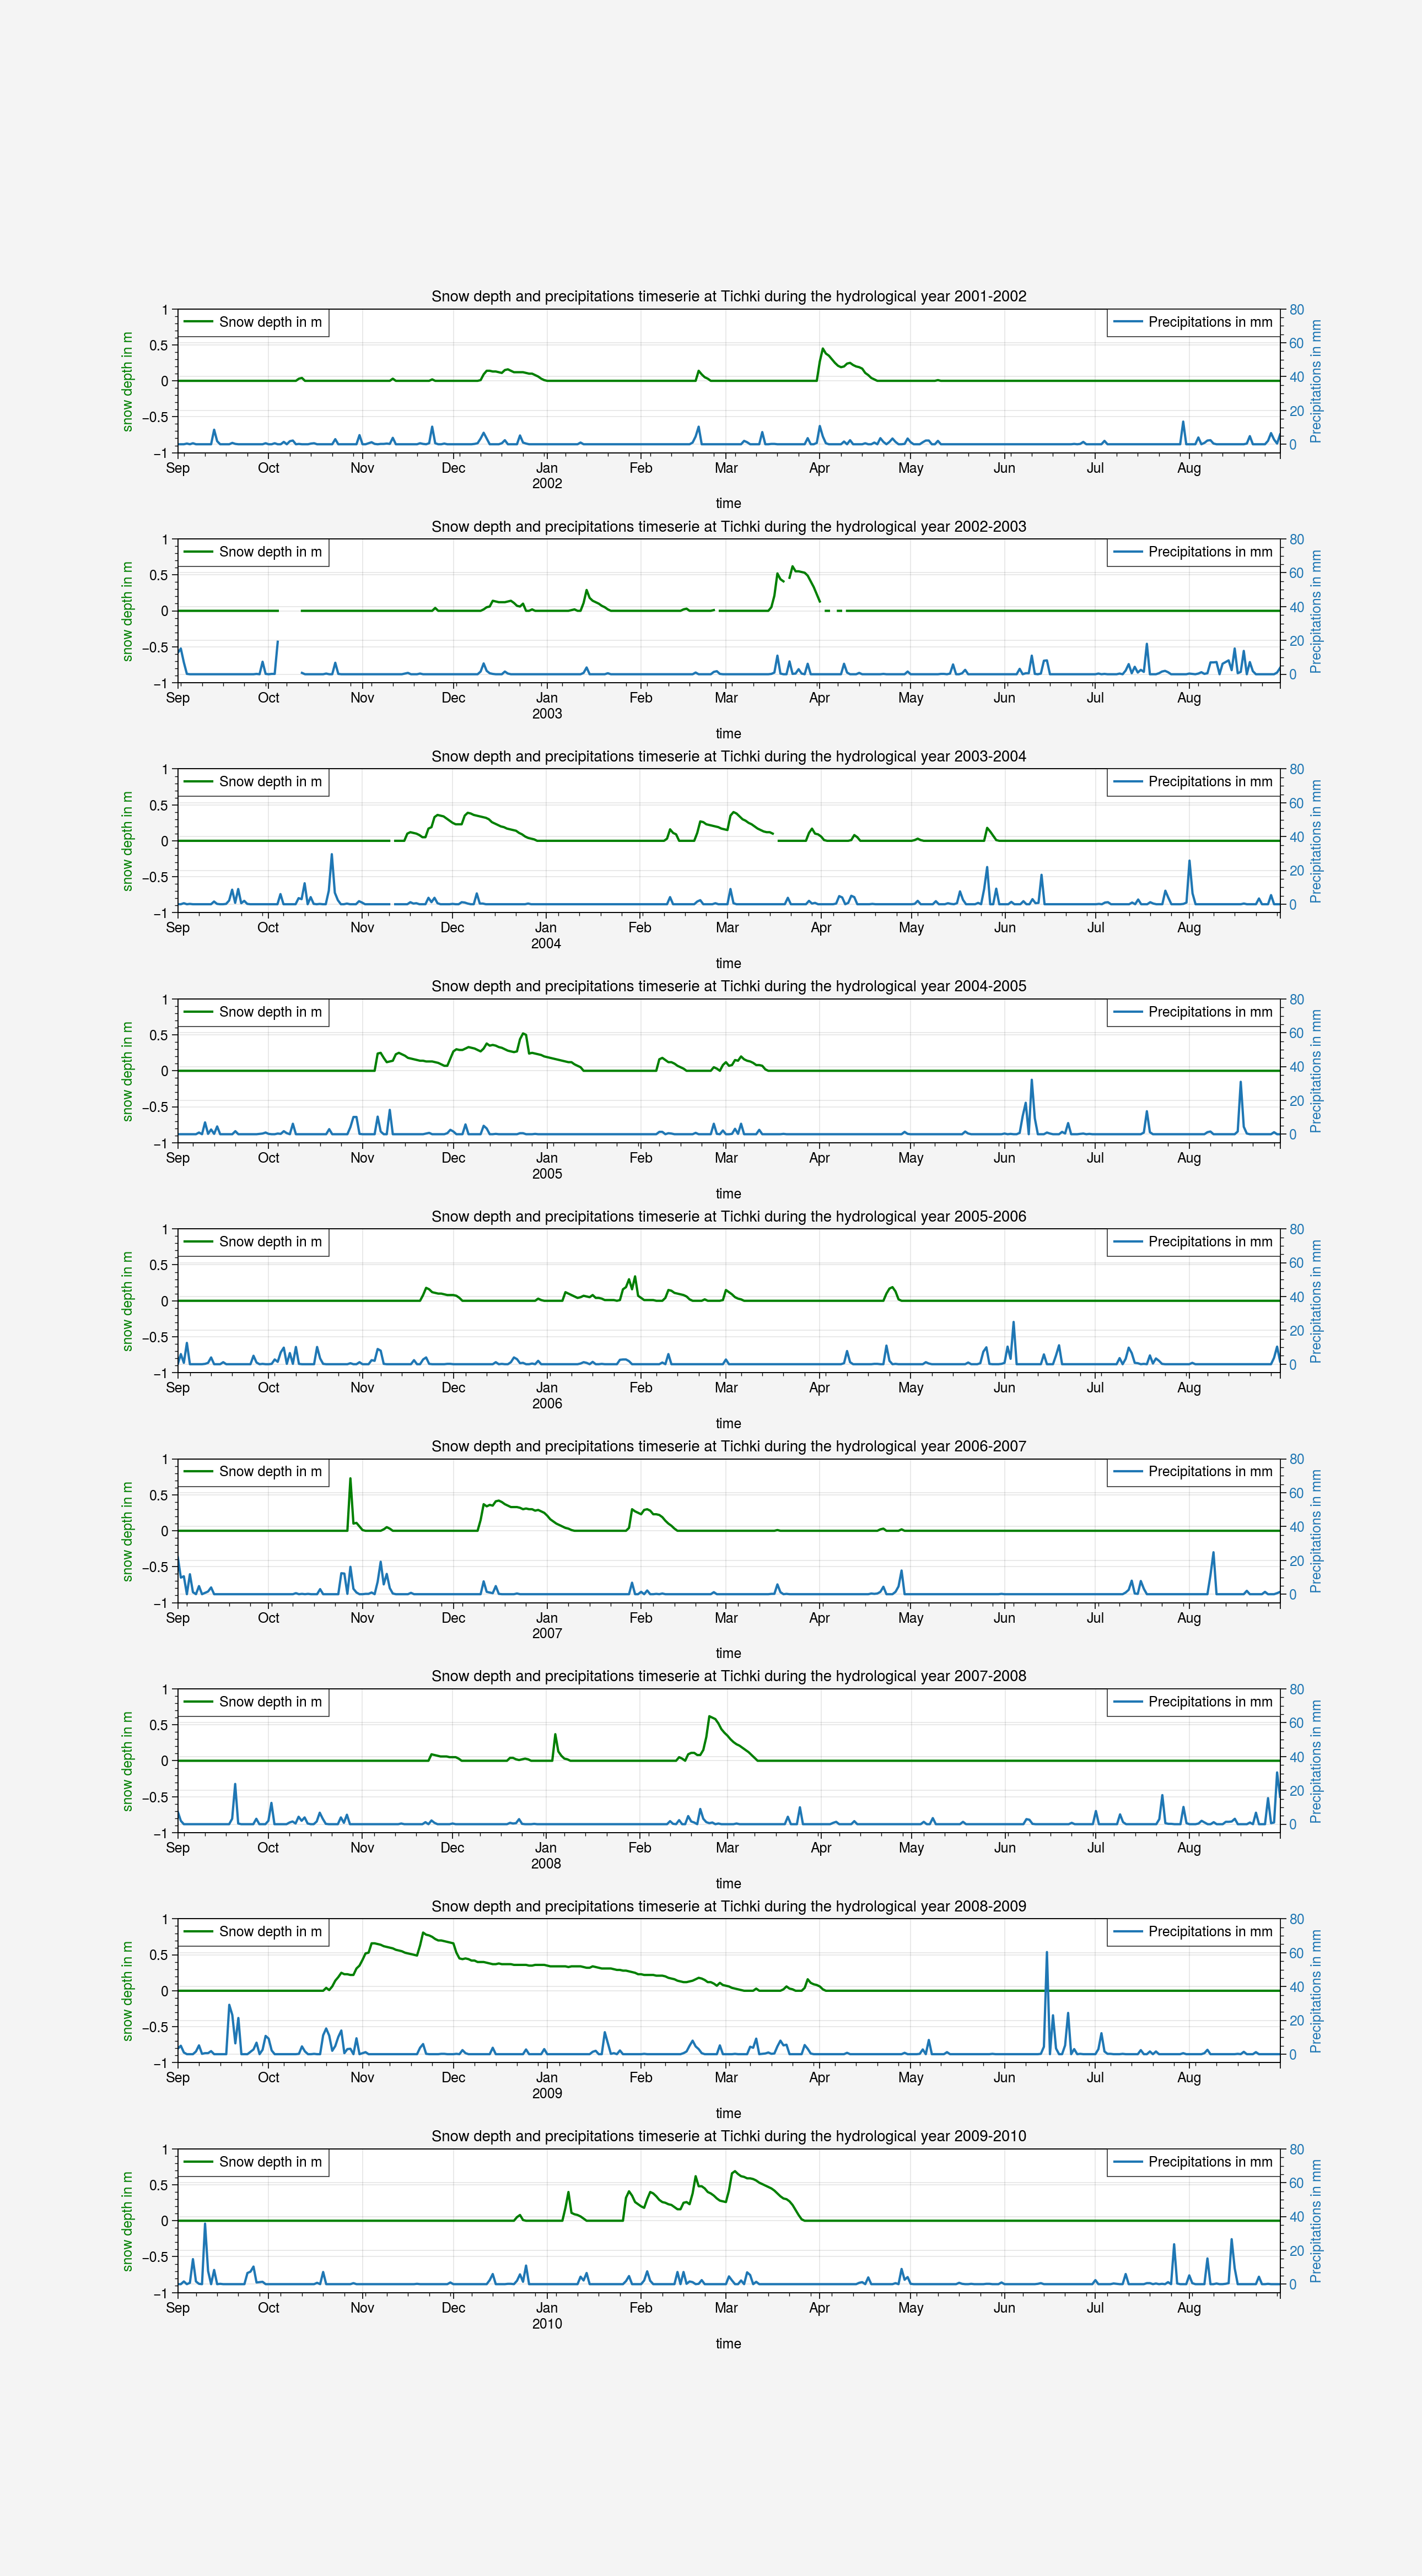

In [29]:
years=["2001-2002","2002-2003","2003-2004","2004-2005","2005-2006","2006-2007","2007-2008", "2008-2009", "2009-2010"]

fig, axs=plt.subplots(9,1)         
plt.subplots_adjust(wspace=0.2,hspace=0.6)
set_size(10,18)


year = 2001
for i in range(9):
    color = 'green'
    tichki['snd_corr'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=axs[i], ylim=[-1,1], color=color) 
    axs[i].set_title("Snow depth and precipitations timeserie at Tichki during the hydrological year "+years[i])
    axs[i].set_xlabel("time")  
    axs[i].set_ylabel("snow depth in m") 
    axs[i].legend(labels = ["Snow depth in m"], loc='upper left')
    axs[i].set_ylabel("snow depth in m", color=color) 
    axs[i].set_ylim(-1,1)

    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Precipitations in mm', color=color)  # we already handled the x-label with ax1
    tichki['p'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=ax2, ylim=[-5,80], color=color) 
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(labels = ["Precipitations in mm"], loc='upper right')
    ax2.set_ylim(-5,80)
    
    year=year+1    
    
plt.savefig('/home/hchaabani/Desktop/results/Simple_vizualisation_In-situ_data_ SD_and_other_pars_Tichki/fig2.png')

### Snow depth and 2m air temperature timeserie at Tichki during the hydrological years of the period 2001-2010

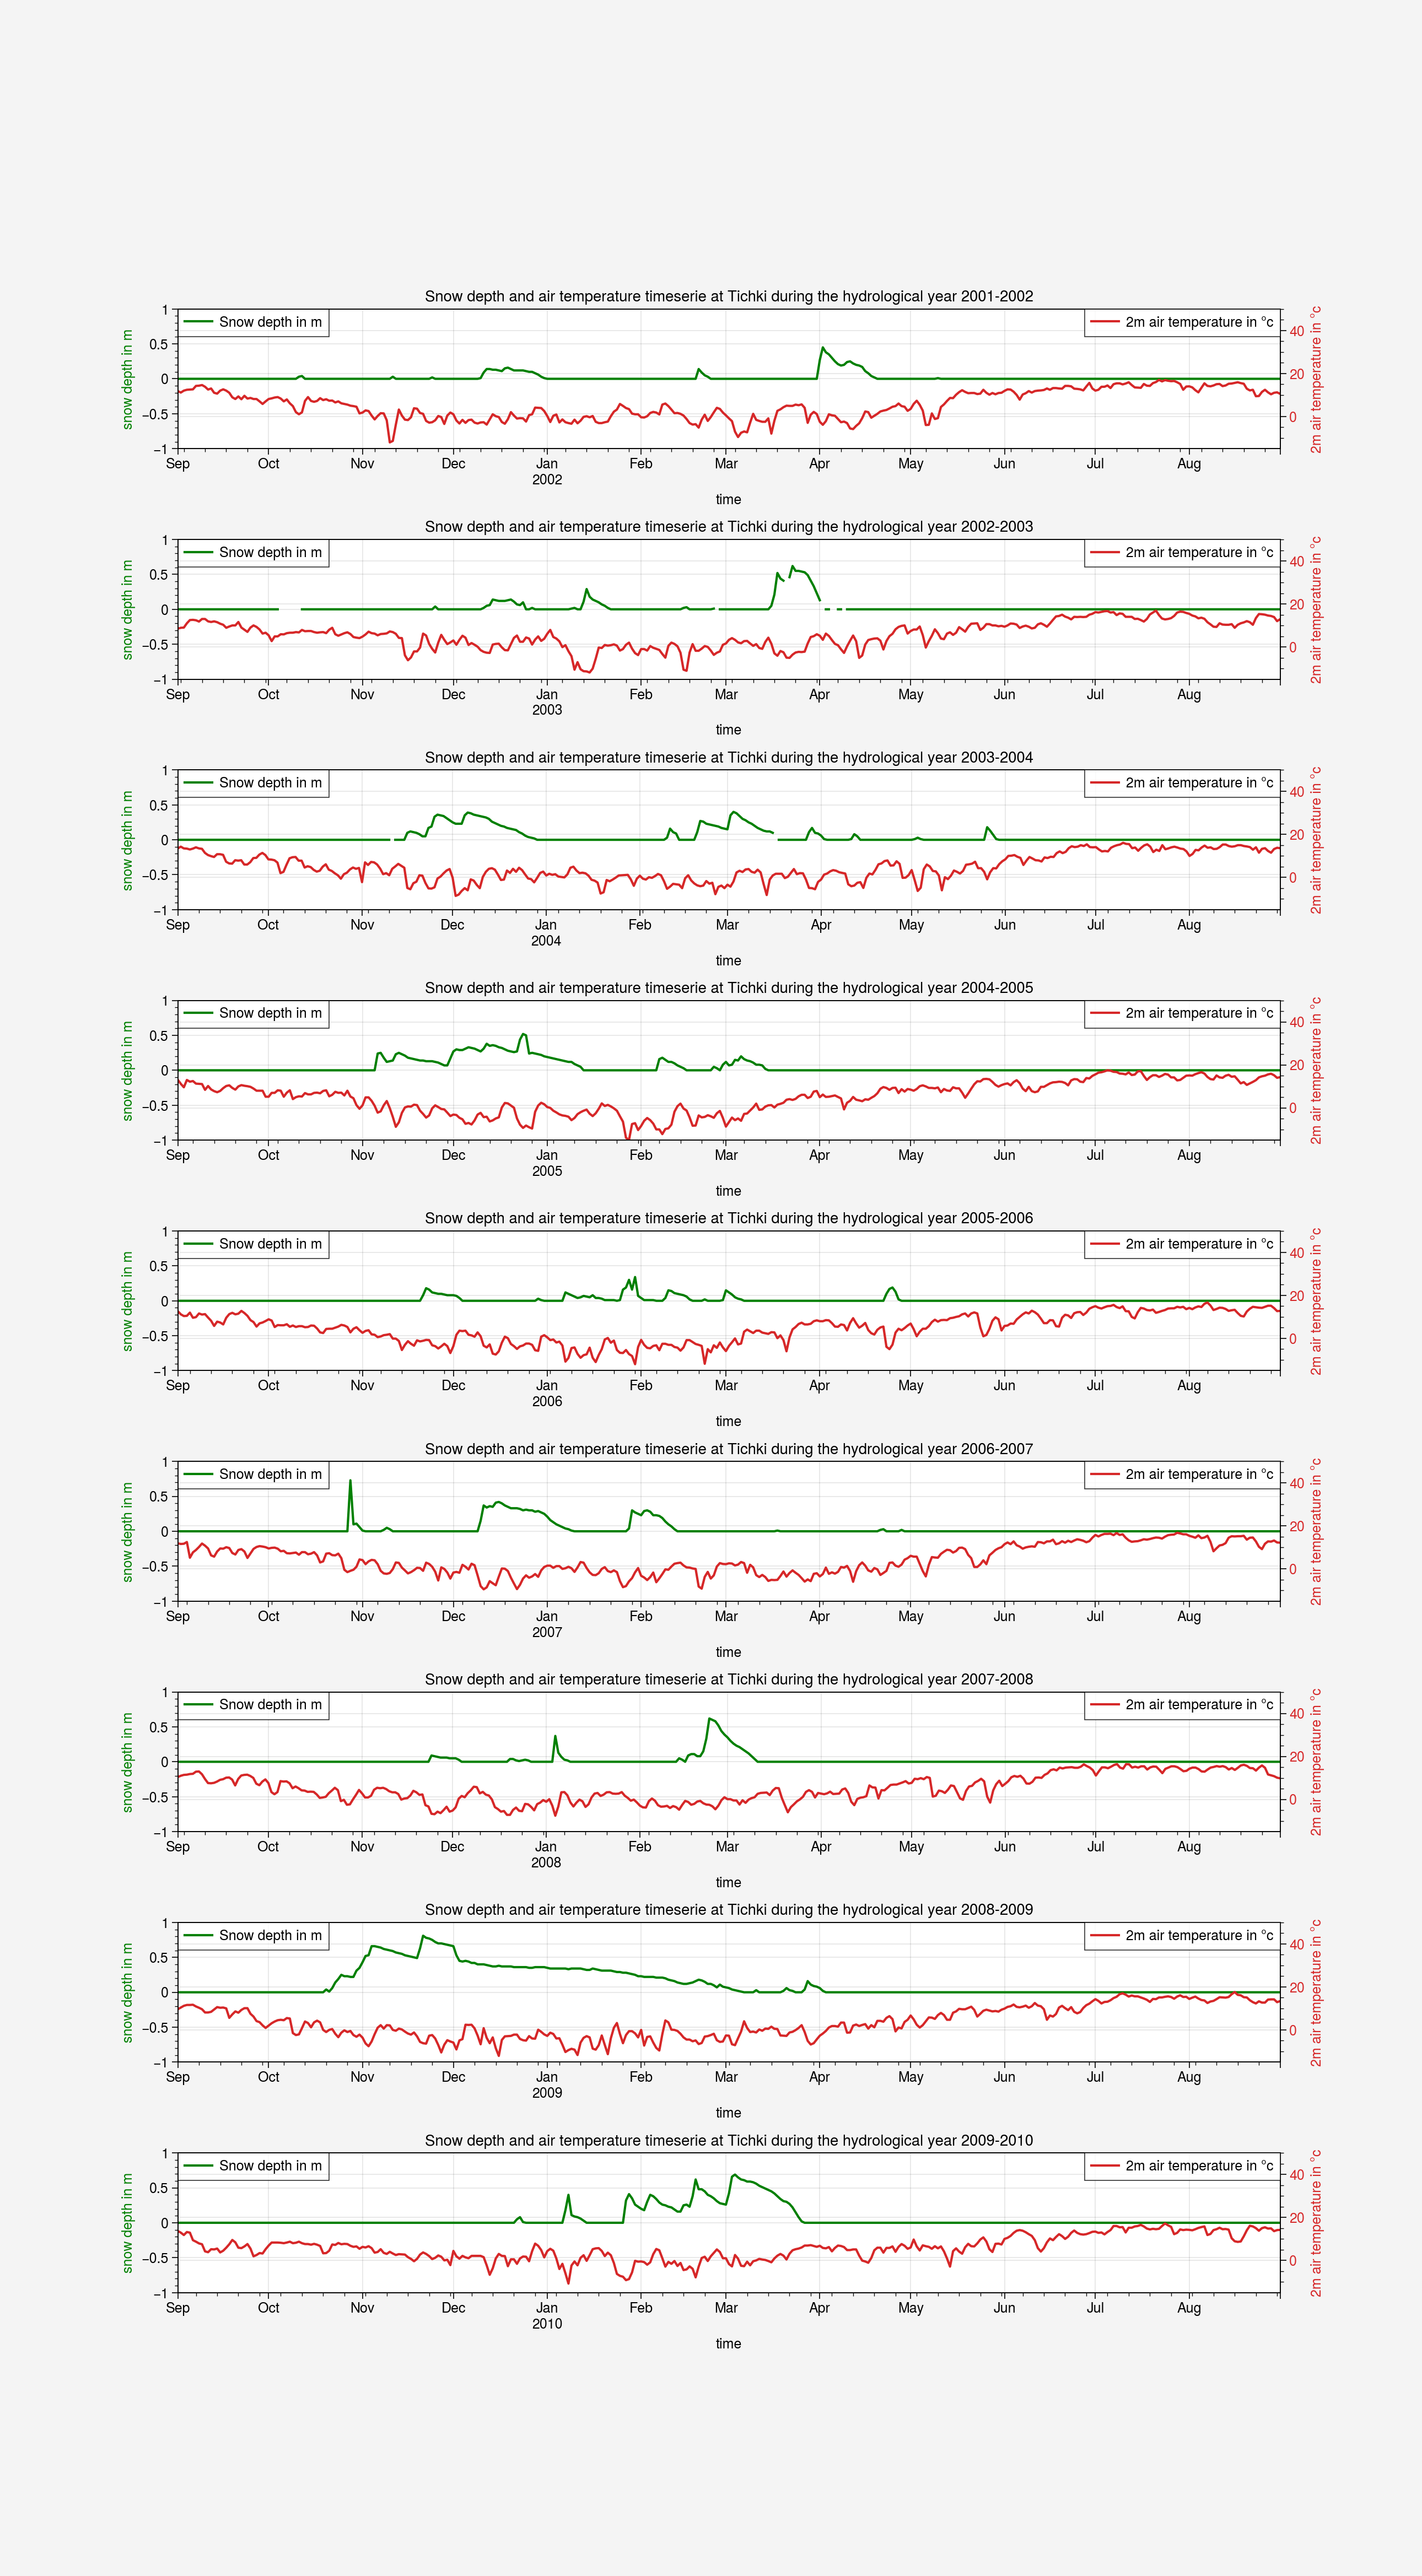

In [30]:
years=["2001-2002","2002-2003","2003-2004","2004-2005","2005-2006","2006-2007","2007-2008", "2008-2009", "2009-2010"]

fig, axs=plt.subplots(9,1)         
plt.subplots_adjust(wspace=0.2,hspace=0.65)
set_size(10,18)


year = 2001
for i in range(9):
    color = 'green'
    tichki['snd_corr'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=axs[i], ylim=[-1,1], color=color) 
    axs[i].set_title("Snow depth and air temperature timeserie at Tichki during the hydrological year "+years[i])
    axs[i].set_xlabel("time")  
    axs[i].set_ylabel("snow depth in m") 
    axs[i].legend(labels = ["Snow depth in m"], loc='upper left')
    axs[i].set_ylabel("snow depth in m", color=color) 
    axs[i].set_ylim(-1,1)

    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('2m air temperature in °c', color=color)  # we already handled the x-label with ax1
    tichki['at_2'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=ax2, ylim=[-15,50], color=color) 
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(labels = ["2m air temperature in °c"], loc='upper right')
    ax2.set_ylim(-15,50)
    
    year=year+1   
    
plt.savefig('/home/hchaabani/Desktop/results/Simple_vizualisation_In-situ_data_ SD_and_other_pars_Tichki/fig3.png')

### Snow depth and 5cm soil temperature timeserie at Tichki during the hydrological years of the period 2001-2010

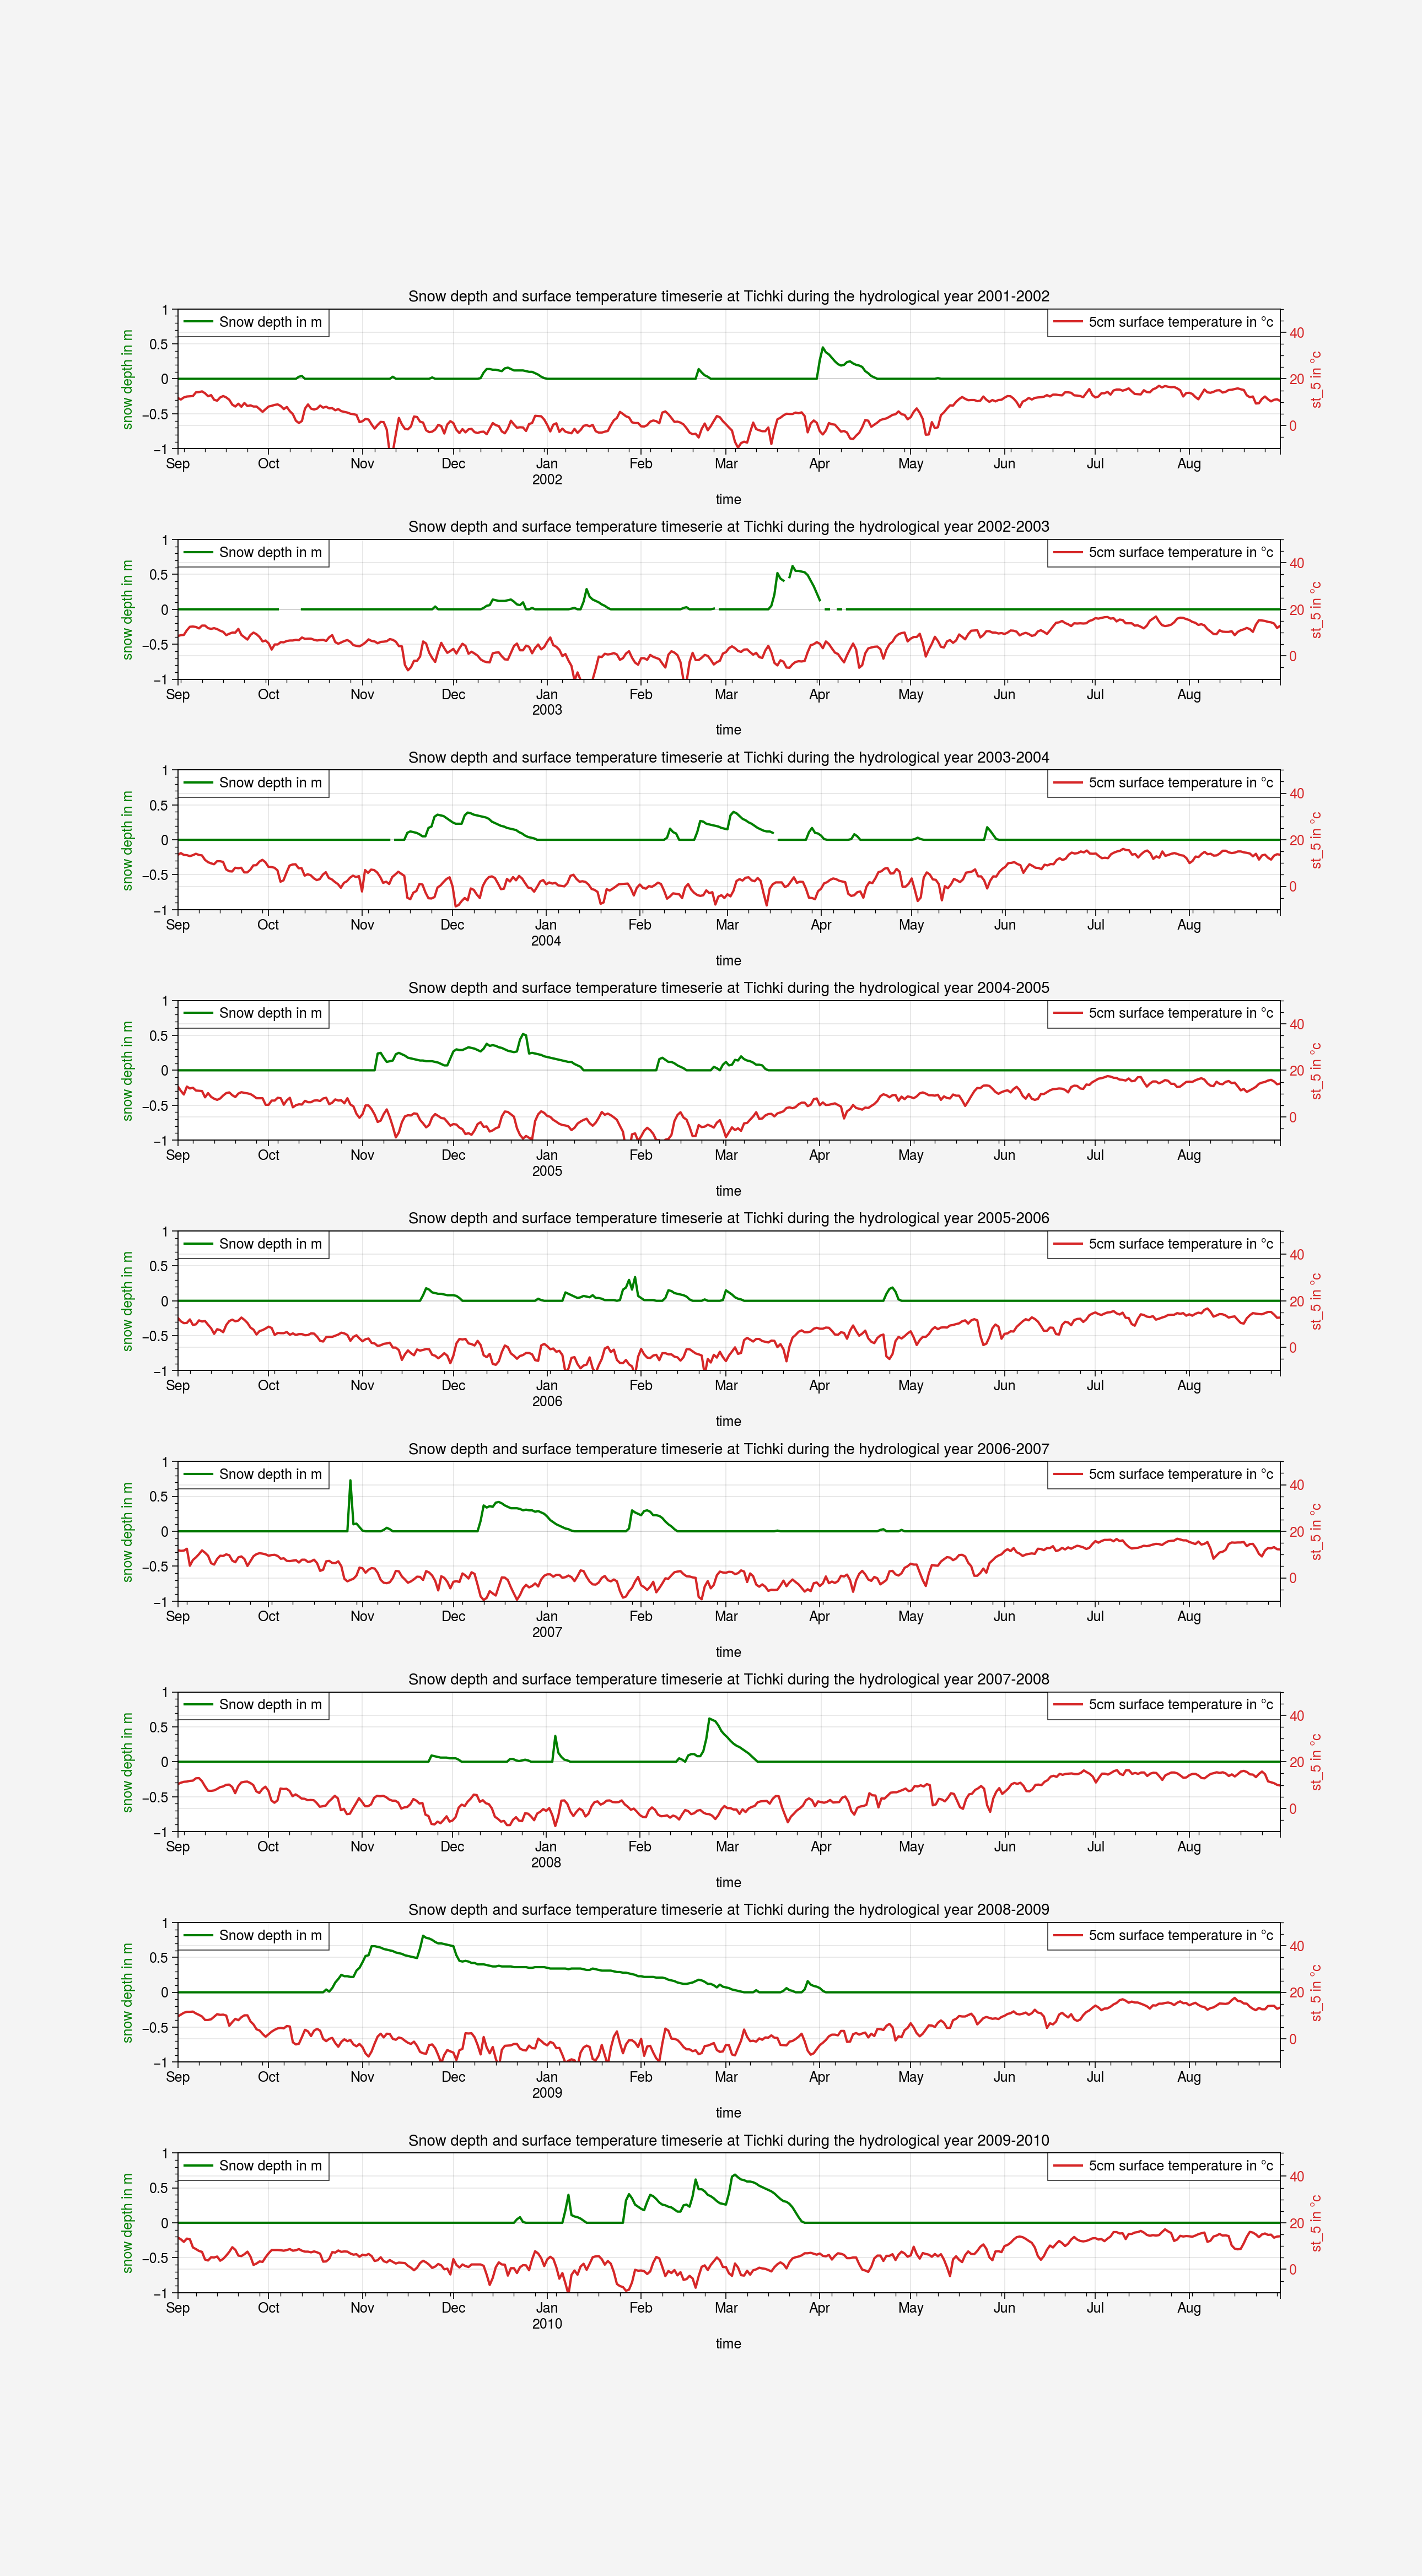

In [31]:
years=["2001-2002","2002-2003","2003-2004","2004-2005","2005-2006","2006-2007","2007-2008", "2008-2009", "2009-2010"]

fig, axs=plt.subplots(9,1)         
plt.subplots_adjust(wspace=0.2,hspace=0.65)
set_size(10,18)


year = 2001
for i in range(9):
    color = 'green'
    tichki['snd_corr'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=axs[i], ylim=[-1,1], color=color) 
    axs[i].set_title("Snow depth and surface temperature timeserie at Tichki during the hydrological year "+years[i])
    axs[i].set_xlabel("time")  
    axs[i].set_ylabel("snow depth in m") 
    axs[i].legend(labels = ["Snow depth in m"], loc='upper left')
    axs[i].set_ylabel("snow depth in m", color=color) 
    axs[i].set_ylim(-1,1)

    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('st_5 in °c', color=color)  # we already handled the x-label with ax1
    tichki['at_2'][str(year)+'-09-01':str(year+1)+'-08-31'].plot(ax=ax2, ylim=[-10,50], color=color) 
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(labels = ["5cm surface temperature in °c"], loc='upper right')
    ax2.set_ylim(-10,50)
    
    year=year+1 
    
plt.savefig('/home/hchaabani/Desktop/results/Simple_vizualisation_In-situ_data_ SD_and_other_pars_Tichki/fig4.png')

#### Number of days with snow per year extrapolated and not extrapolated 

In [32]:
tichki

date snd_corr at_2 st-5    p  year  month
str_date                                                  
2001-01-01 2001-01-01      NaN  NaN  NaN  NaN  2001      1
2001-01-02 2001-01-02      NaN  NaN  NaN  NaN  2001      1
2001-01-03 2001-01-03      NaN  NaN  NaN  NaN  2001      1
2001-01-04 2001-01-04      NaN  NaN  NaN  NaN  2001      1
2001-01-05 2001-01-05      NaN  NaN  NaN  NaN  2001      1
...               ...      ...  ...  ...  ...   ...    ...
2010-12-27 2010-12-27        0  2.7  1.4    0  2010     12
2010-12-28 2010-12-28        0 -0.1    2    0  2010     12
2010-12-29 2010-12-29        0 -0.5    2    0  2010     12
2010-12-30 2010-12-30        0 -2.8  0.9    0  2010     12
2010-12-31 2010-12-31        0  0.5  1.6    0  2010     12

[3652 rows x 7 columns]

##### On the scale of a year

In [33]:
aux = tichki[['date', 'year', 'month' , 'snd_corr']]

In [34]:
aux

date  year  month snd_corr
str_date                                   
2001-01-01 2001-01-01  2001      1      NaN
2001-01-02 2001-01-02  2001      1      NaN
2001-01-03 2001-01-03  2001      1      NaN
2001-01-04 2001-01-04  2001      1      NaN
2001-01-05 2001-01-05  2001      1      NaN
...               ...   ...    ...      ...
2010-12-27 2010-12-27  2010     12        0
2010-12-28 2010-12-28  2010     12        0
2010-12-29 2010-12-29  2010     12        0
2010-12-30 2010-12-30  2010     12        0
2010-12-31 2010-12-31  2010     12        0

[3652 rows x 4 columns]

In [35]:
aux = aux.set_index('year')

In [36]:
NDS=aux['snd_corr'].where(aux['snd_corr'] > 0).groupby('year').count()
NDSWE=aux['snd_corr'].where(aux['snd_corr'] > 0).groupby('year').count() * 365 / (aux['snd_corr'].where(aux['snd_corr'] > 0).groupby('year').count() + aux['snd_corr'].where(aux['snd_corr'] == 0).groupby('year').count())

In [37]:
NDS

year
2001     28
2002     40
2003     73
2004    102
2005     53
2006     81
2007     46
2008    103
2009     80
2010     68
Name: snd_corr, dtype: int64

In [38]:
NDSWE

year
2001     37.573529
2002     40.782123
2003     74.427374
2004    102.000000
2005     53.000000
2006     81.000000
2007     46.000000
2008    102.718579
2009     80.000000
2010     68.000000
Name: snd_corr, dtype: float64

In [39]:
data = pd.concat([NDSWE, NDS], axis=1)

In [40]:
data

snd_corr  snd_corr
year                      
2001   37.573529        28
2002   40.782123        40
2003   74.427374        73
2004  102.000000       102
2005   53.000000        53
2006   81.000000        81
2007   46.000000        46
2008  102.718579       103
2009   80.000000        80
2010   68.000000        68

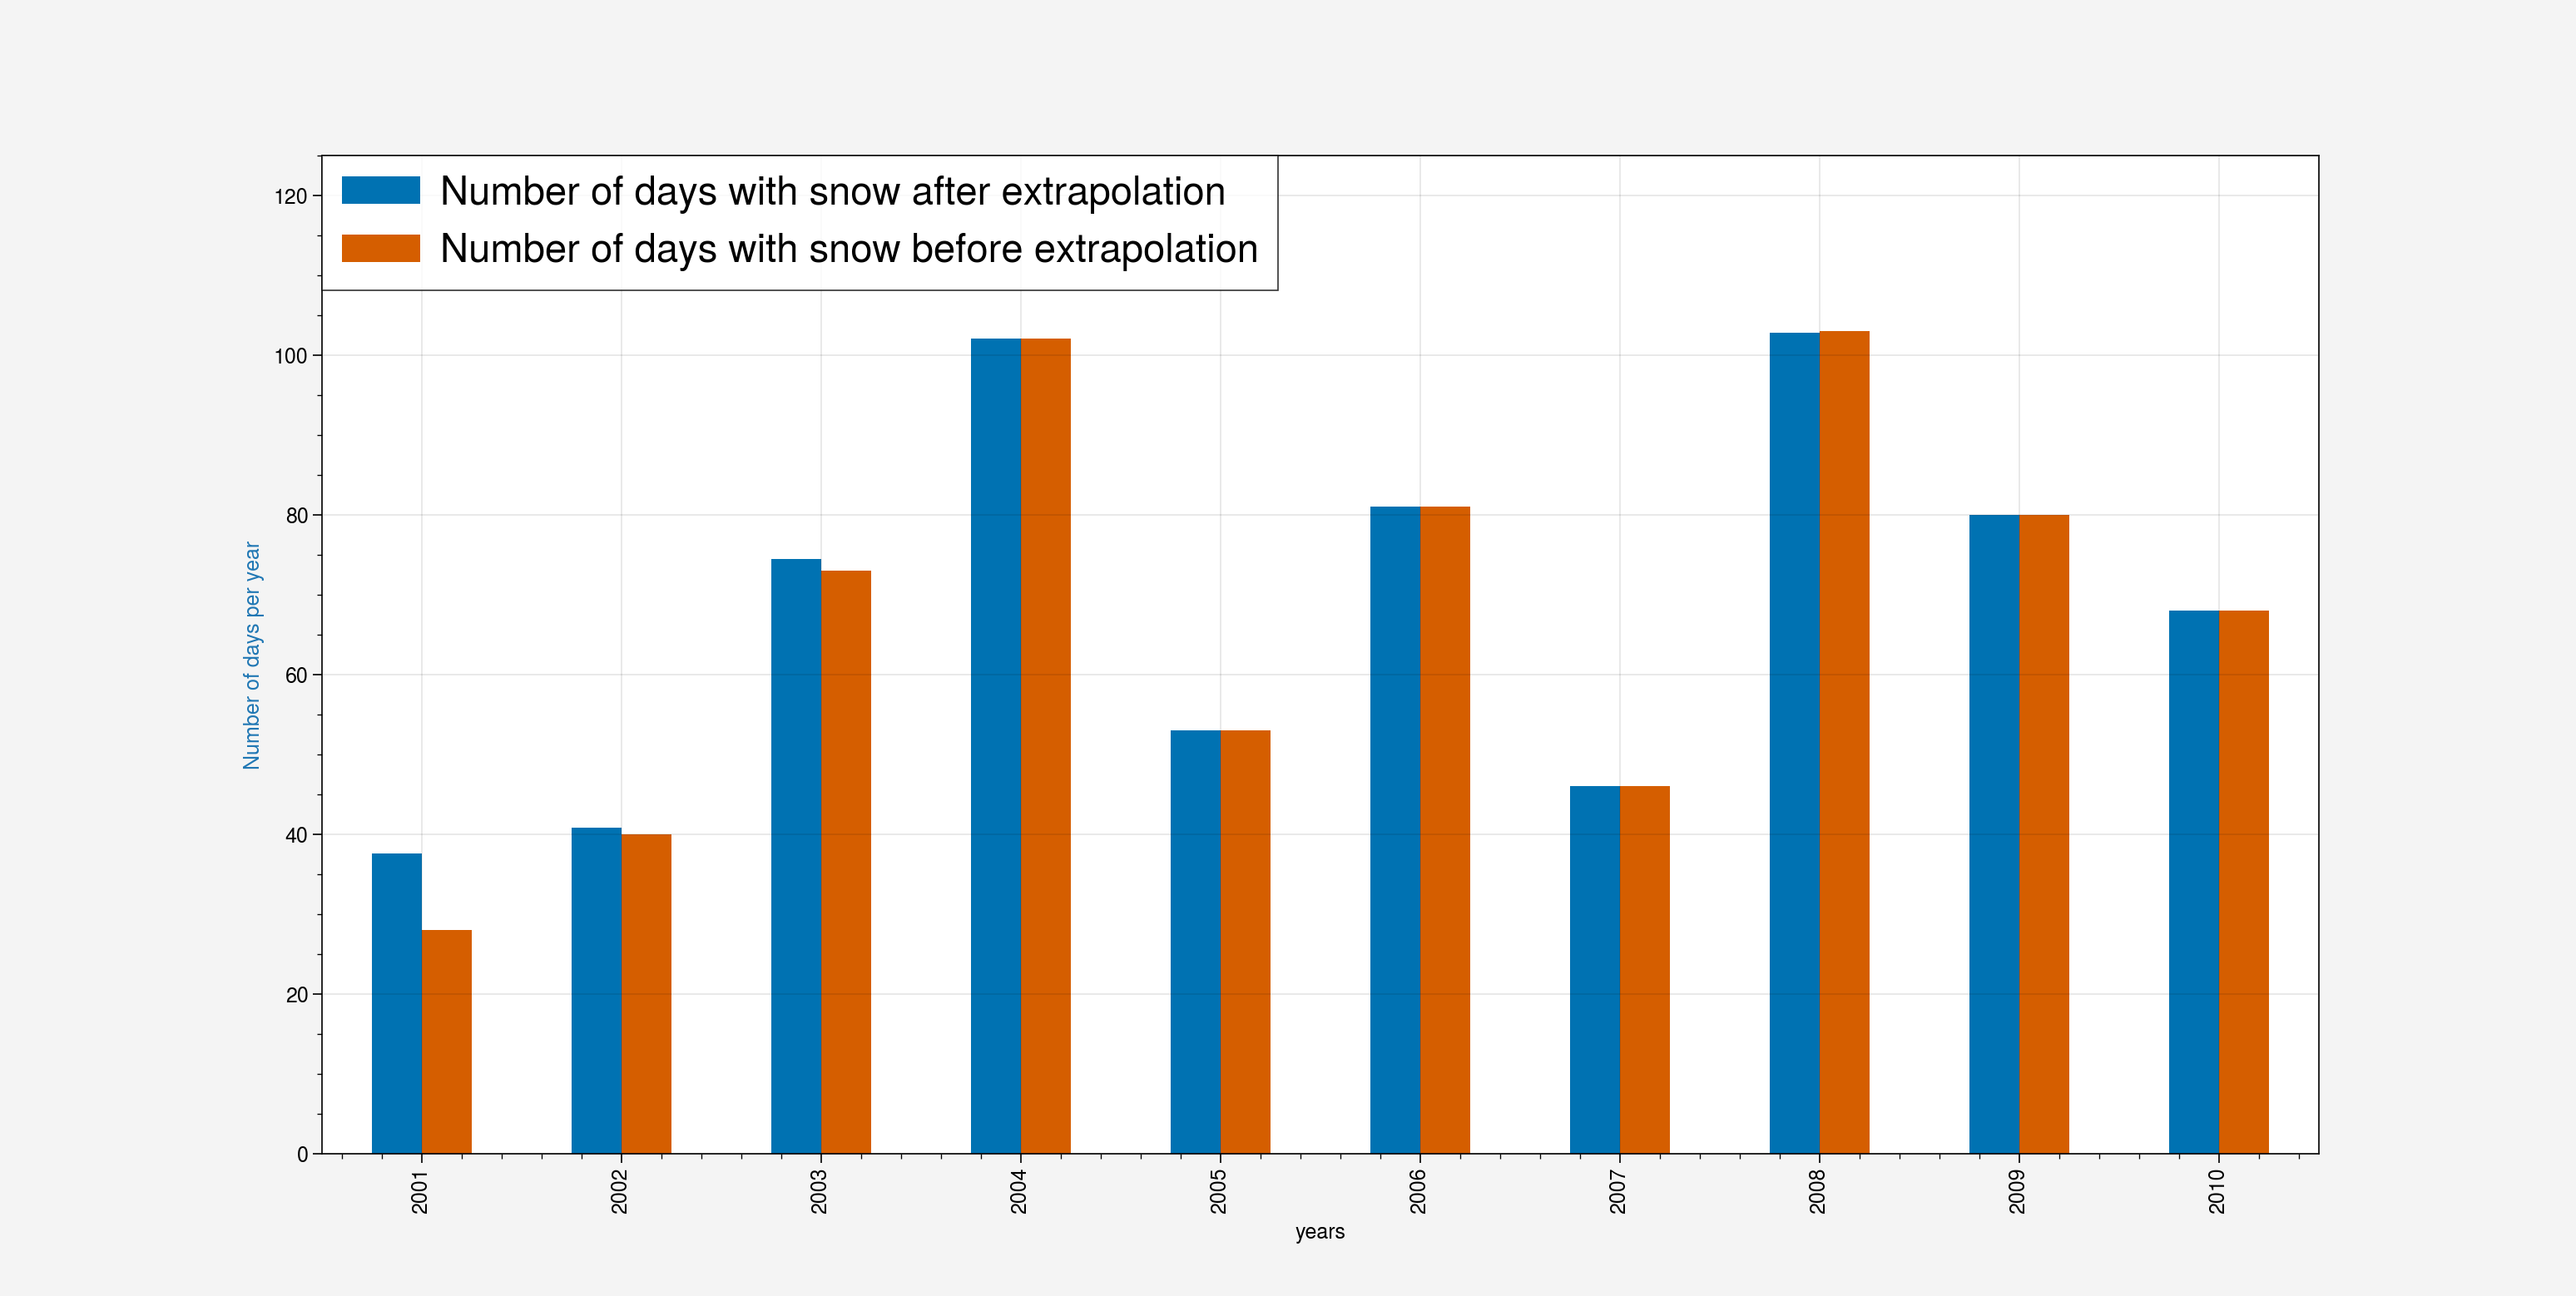

In [41]:
Noms=["Tichki (3260m)"]
fig, ax=plt.subplots() 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.1,hspace=0.65)

# We fix the size of figure
set_size(12,6)     

, female, width=0.4
color1 = 'tab:blue'
color2 = 'tab:brown'
data.plot.bar(ax=ax)
#ax.set_title("Number of days with snow per year at Tichki over the period 2001-2010")
ax.set_xlabel("years") 
ax.legend(labels = ["Number of days with snow after extrapolation", "Number of days with snow before extrapolation"], loc='upper left', fontsize = 17)
ax.set_ylabel("Number of days per year", color=color1) 
ax.set_ylim(0,125)

plt.savefig('/home/hchaabani/Desktop/results/Simple_vizualisation_In-situ_data_ SD_and_other_pars_Tichki/fig5.png')

##### On the scale of a month

In [42]:
aux = tichki[['date', 'year', 'month' , 'snd_corr']]

In [43]:
aux = aux.set_index('month')

In [44]:
NDS=aux['snd_corr'].where(aux['snd_corr'] > 0).groupby('month').count()/10
NDSWE=aux['snd_corr'].where(aux['snd_corr'] > 0).groupby('month').count() * 365 / (aux['snd_corr'].where(aux['snd_corr'] > 0).groupby('month').count() + aux['snd_corr'].where(aux['snd_corr'] == 0).groupby('month').count())/10

In [45]:
NDS = NDS.astype(int)

In [46]:
NDS

month
1     10
2     13
3     10
4      3
5      0
6      0
7      0
8      0
9      0
10     1
11     9
12    16
Name: snd_corr, dtype: int64

In [47]:
NDSWE = NDSWE.astype(int)

In [48]:
NDSWE 

month
1     14
2     19
3     14
4      4
5      0
6      0
7      0
8      0
9      0
10     2
11    11
12    19
Name: snd_corr, dtype: int64

In [49]:
data = pd.concat([NDSWE, NDS], axis=1)

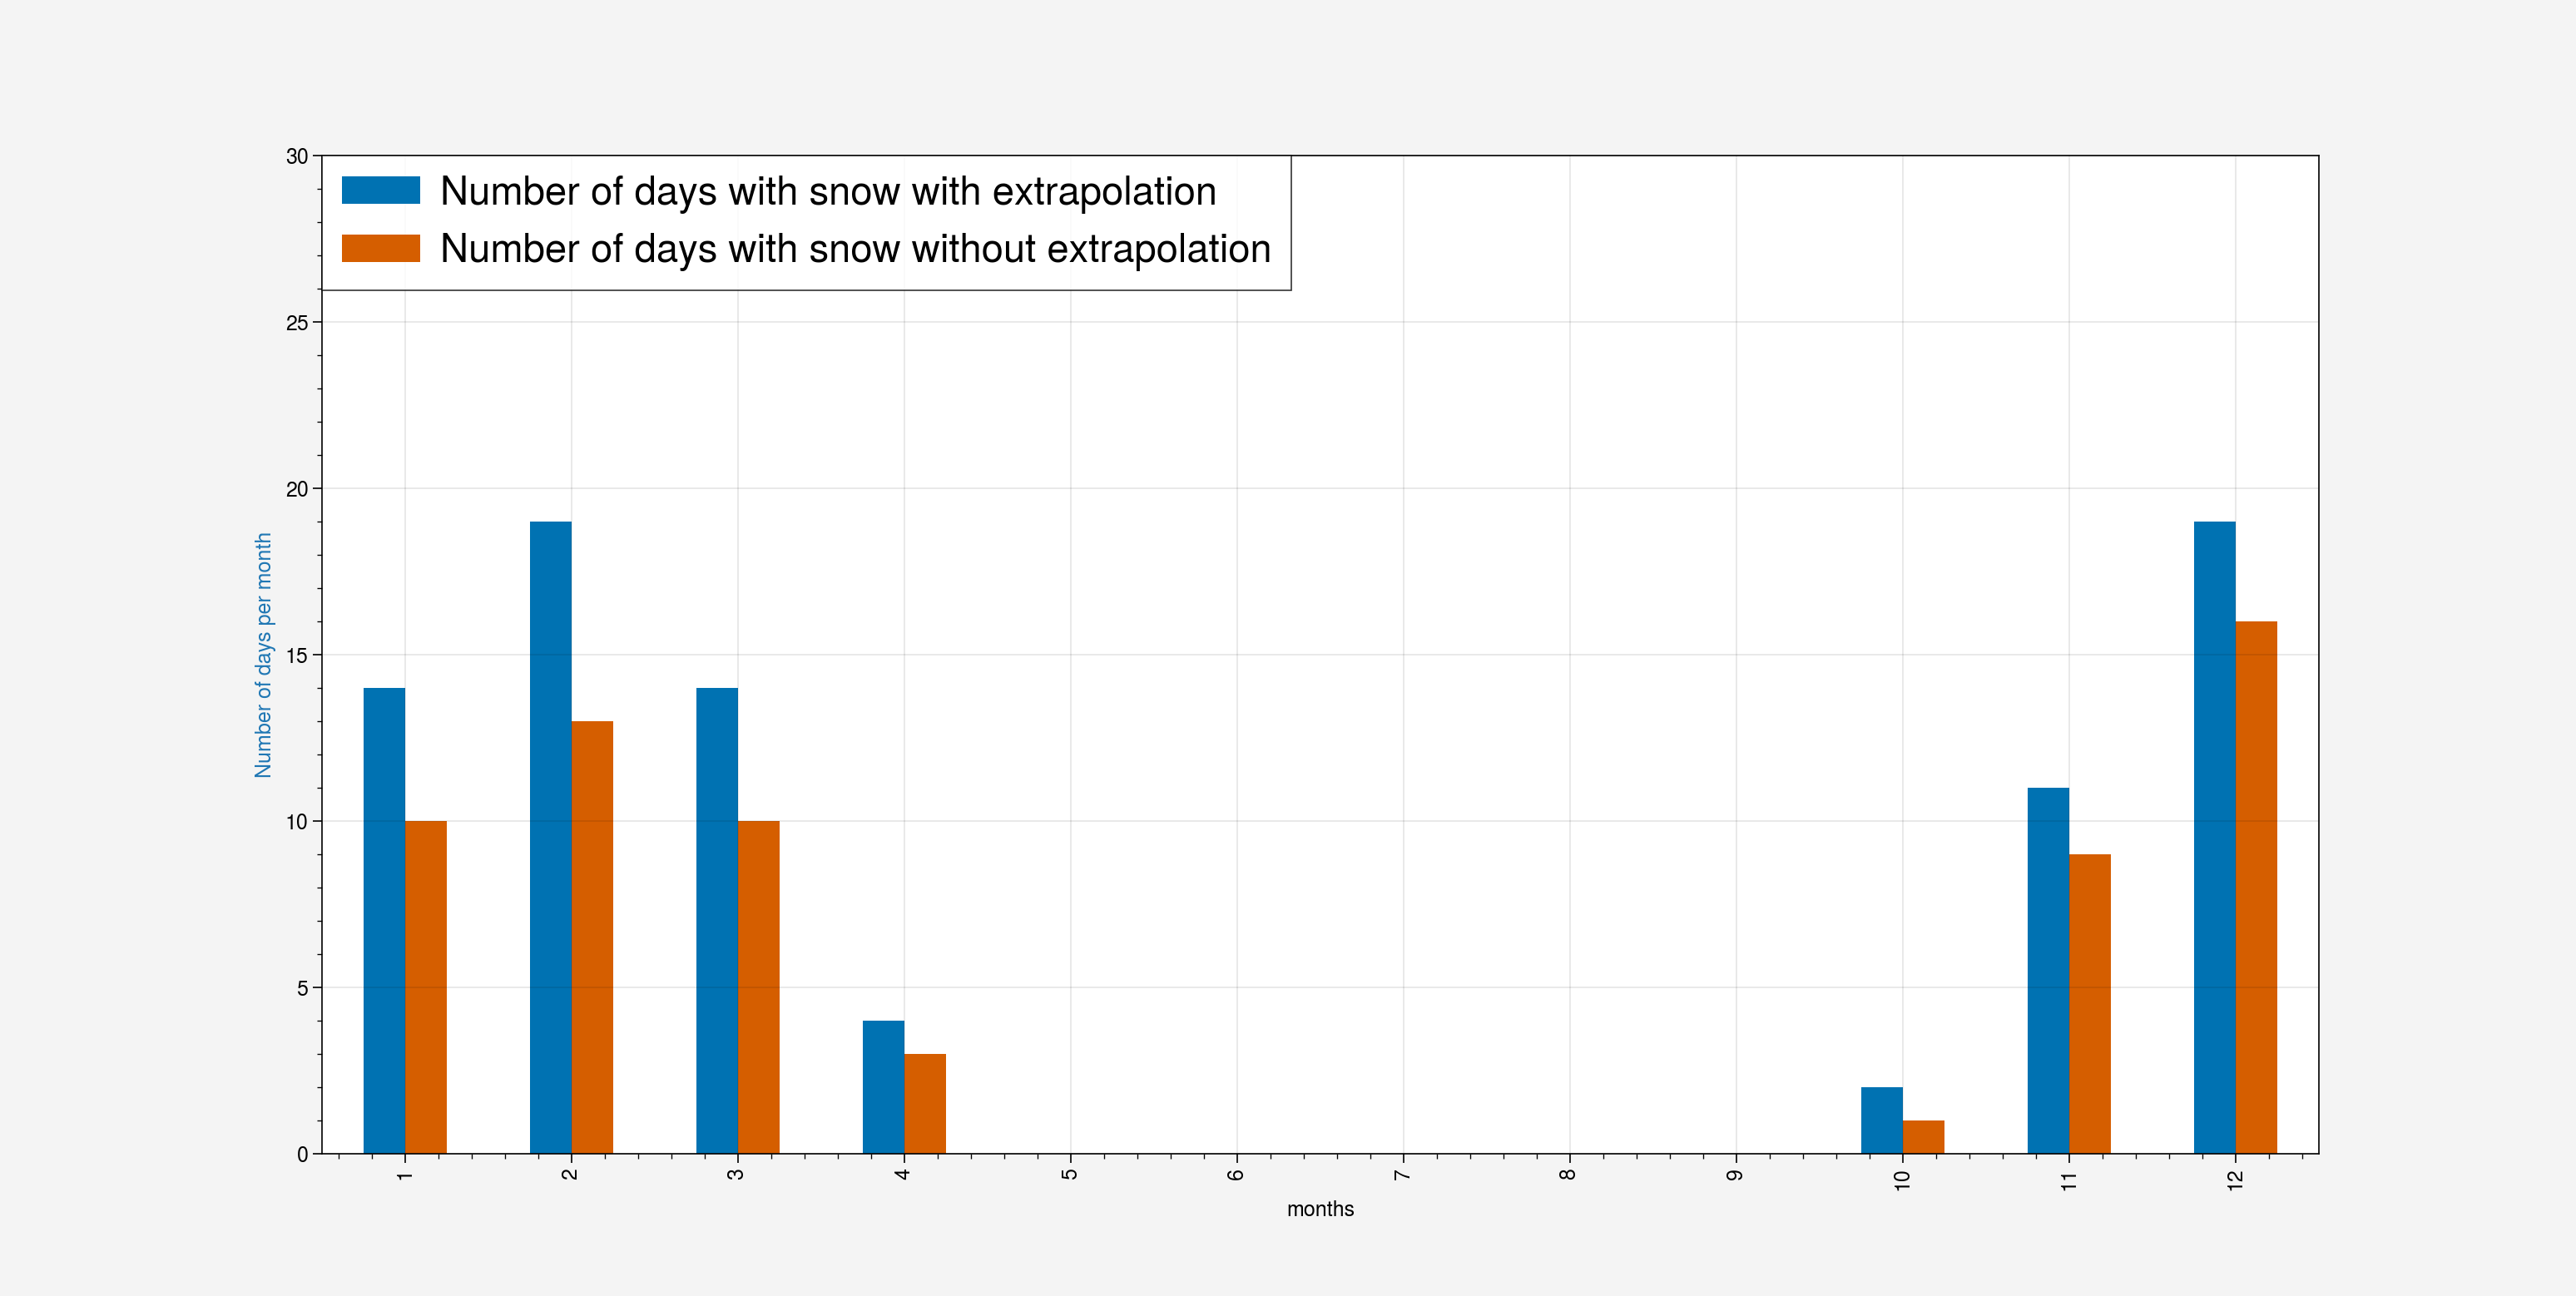

In [50]:
Noms=["Tichki (3260m)"]
fig, ax=plt.subplots() 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.1,hspace=0.65)

# We fix the size of figure
set_size(12,6)     

, female, width=0.4
color1 = 'tab:blue'
color2 = 'tab:brown'
data.plot.bar(ax=ax)
#ax.set_title("Monthly mean of the number of days with snow per month at Tichki over the period 2001-2010")
ax.set_xlabel("months") 
ax.legend(labels = ["Number of days with snow with extrapolation", "Number of days with snow without extrapolation"], loc='upper left', fontsize = 17)
ax.set_ylabel("Number of days per month", color=color1) 
ax.set_ylim(0,30)

plt.savefig('/home/hchaabani/Desktop/results/Simple_vizualisation_In-situ_data_ SD_and_other_pars_Tichki/fig6.png')